In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import logging
import scipy.stats as sts
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import os

from arch import arch_model

In [2]:
ini_work_dir = os.getcwd()
os.chdir('..')

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from antecedent_fitting import fit_antecedent_params
from local_models import calculate_retraining_garch_forecasts

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']
RESEARCH_RESULTS_FOLDER = config['files_folders']['research_results']
antecedent_params_folder = config['files_folders']['antecedent_params_sets']
logs_folder = config['files_folders']['logs']

In [6]:
TESTED_MODEL_FILE_NAME = 'tested_model_wo_seas'

In [7]:
logger = logging.getLogger(f'test_calc')  # apf == antecedent params fitting

_log_file = f'{logs_folder}/{logger.name}.log'
logging.basicConfig(level=logging.INFO,
                    filename=_log_file,
                    filemode='w',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S')

In [8]:
pd.options.display.precision = 15
pd.options.display.max_colwidth = 300

# Reading

In [10]:
_files = ['fitting_consequent_params_wo_seas_result_nb_0_2022-09-25 00-55-40.814296.pkl']
res_big = [pd.read_pickle(f'{RESEARCH_RESULTS_FOLDER}/{_file}') for _file in _files]
_res = [_elem for res_piece in res_big for _elem in res_piece['result']].copy()

res = pd.DataFrame.from_records(_res).copy()

In [11]:
if (res['status'] != 0).any():
    raise Error('Not all models were fitted')

In [12]:
fitted_ap = res[res['rmse'] == res['rmse'].min()].iloc[0]['antecedent_params'].copy()
fitted_ap

[{'centers': (-7.5, -3.5, -0.5, 2.0),
  'variances': (4, 6, 4, 4),
  'n_clusters': 4}]

In [13]:
fvm = res[res['rmse'] == res['rmse'].min()].iloc[0]['fvm']

In [14]:
test = res_big[0]['test'].copy()
data_to_cluster_test = res_big[0]['data_to_cluster_test'].copy()

# Live feeding

In [15]:
%%time

fvm.feed_daily_data(test, data_to_cluster=data_to_cluster_test)

CPU times: user 45.7 s, sys: 400 ms, total: 46.1 s
Wall time: 46.6 s


In [16]:
_cur_time = str(pd.Timestamp.today()).replace(':', '-')
print(_cur_time)

with open(f'{RESEARCH_RESULTS_FOLDER}/{TESTED_MODEL_FILE_NAME}_{_cur_time}.pkl', 'wb') as _file:
    pickle.dump(fvm, _file)

2022-09-25 15-24-10.378366


In [17]:
fvm.hist_output

2014-05-30    0.000396770770524
2014-06-02    0.000416221548082
2014-06-03    0.000455725541958
2014-06-04    0.000383610998869
2014-06-05    0.000383487243193
2014-06-06    0.000391230381096
2014-06-09    0.000446692402446
2014-06-10    0.000386967789717
2014-06-11    0.000391278817766
2014-06-16    0.000390031286793
dtype: float128

In [18]:
fvm.membership_degrees_hist

,0,1,2,3
<DATE>,,,,
2014-05-30,3.760831800268592e-31,0.000006494913675,0.990717606105122,0.009275898981203
2014-06-02,3.770562331442529e-31,0.000006499334665,0.990726050837750,0.009267449827585
2014-06-03,3.807482724769588e-31,0.000006516084806,0.990757827152686,0.009235656762508
2014-06-04,3.898622830305070e-31,0.000006556900110,0.990834520715169,0.009158922384722
2014-06-05,3.831472400576166e-31,0.000006526867640,0.990778252552385,0.009215220579975
2014-06-06,3.775158160636567e-31,0.000006501438309,0.990730029141661,0.009263469420030
2014-06-09,3.808440895056279e-31,0.000006516528703,0.990758646274864,0.009234837196433
2014-06-10,3.585815660486332e-31,0.000006413368656,0.990560497316669,0.009433089314675
2014-06-11,3.572192965265016e-31,0.000006406921900,0.990547835680541,0.009445757397559


In [26]:
fvm._parameters_hist

[{'alpha_0': array([2.41731162e-05, 3.76626310e-04, 3.76521343e-04, 3.76521338e-04]),
  'alpha': array([[0.011535  , 0.17461486, 0.17049592, 0.17050462]]),
  'beta': array([[4.96677657e-01, 1.27357571e-18, 1.49100337e-18, 1.49288383e-18]])},
 {'alpha_0': array([2.41731162e-05, 5.59191453e-04, 3.81337737e-04, 2.20369823e-04],
        dtype=float128),
  'alpha': array([[0.12177931, 0.17626356, 0.17238502, 0.17216472]], dtype=float128),
  'beta': array([[9.99999796e-01, 1.19406450e-11, 1.18044752e-11, 1.19393746e-11]],
        dtype=float128)},
 {'alpha_0': array([2.41731162e-05, 4.25597040e-02, 3.87069173e-04, 1.28275489e-05],
        dtype=float128),
  'alpha': array([[0.12177931, 0.17364973, 0.17181697, 0.17206471]], dtype=float128),
  'beta': array([[9.99999796e-01, 9.20793805e-11, 8.70915687e-11, 9.20229214e-11]],
        dtype=float128)},
 {'alpha_0': array([2.41731162e-05, 4.25042939e-02, 3.86565364e-04, 1.28108525e-05]),
  'alpha': array([[0.99999997, 0.17298812, 0.17130222, 0.171

In [27]:
res_big[0].keys()

dict_keys(['result', 'fitted', 'train', 'test', 'antecedent_params_set', 'consequent_metaparams', 'consequent_params_ini', 'clusterization_method', 'local_method', 'data_to_cluster_train', 'data_to_cluster_test'])

In [28]:
mse = mean_squared_error(fvm.hist_output, test ** 2, squared=True)
rmse = mean_squared_error(fvm.hist_output, test ** 2, squared=False)

In [29]:
rmse

0.00031955134767811518757

In [30]:
mse

1.0211306380289965267e-07

<AxesSubplot:xlabel='<DATE>'>

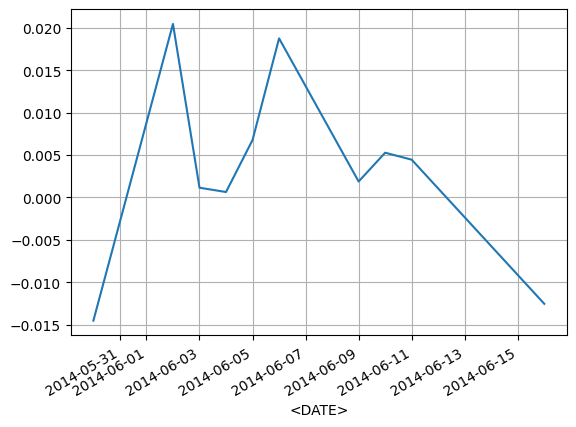

In [35]:
test.plot(grid=True)